In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import joblib
import numpy as np
import pandas as pd

class StanceModel:
    def __init__(self, model_dir="saved_models", batch_size=32, epochs=3, device=None):
        self.model_dir = model_dir
        self.analyzer = SentimentIntensityAnalyzer()
        self.model = None
        self.tfidf = None
        self.label_encoder = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    def load_data(self, file_path):
        for encoding in ['utf-8', 'latin1']:
            try:
                return pd.read_csv(file_path,
                                   sep='\t',
                                   encoding=encoding,
                                   engine='python',
                                   on_bad_lines='skip',
                                   names=['label', 'text'],
                                   header=None)
            except Exception:
                continue
        raise ValueError(f"❌ Could not load file: {file_path}")

    def preprocess(self, df):
        df = df.dropna(subset=['text', 'label'])
        texts = df['text'].astype(str).str.strip()
        labels = df['label'].astype(str).str.strip()
        labels = labels[labels != 'label']  # Remove accidental header rows
        texts = texts[labels.index]
        return texts, labels

    def extract_sentiment(self, texts):
        features = []
        for text in texts:
            try:
                sentiment = self.analyzer.polarity_scores(text)
                features.append([sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']])
            except:
                features.append([0, 1.0, 0, 0])  # Neutral fallback
        return np.array(features)

    def fit(self, train_df):
        texts, labels = self.preprocess(train_df)
        sentiment_features = self.extract_sentiment(texts)

        self.tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
        tfidf_features = self.tfidf.fit_transform(texts)

        self.label_encoder = LabelEncoder()
        labels_encoded = self.label_encoder.fit_transform(labels)

        X = np.hstack([tfidf_features.toarray(), sentiment_features])
        y = labels_encoded

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)

        train_data = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        self.model = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(np.unique(y))),
            nn.Softmax(dim=1)
        ).to(self.device)

        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            self.model.train()
            all_preds = []
            all_labels = []
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for batch in train_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
                correct_predictions += (predicted == y_batch).sum().item()
                total_predictions += y_batch.size(0)

            accuracy = correct_predictions / total_predictions * 100
            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(f"Training accuracy after epoch {epoch + 1}: {accuracy:.2f}%")
            print("Training classification report:")
            print(classification_report(all_labels, all_preds, target_names=self.label_encoder.classes_))
            print(f"Epoch {epoch + 1} completed.\n")

        # Save the model after completing all epochs
        self.save()

    def evaluate(self, test_df):
        texts, labels = self.preprocess(test_df)
        sentiment_features = self.extract_sentiment(texts)
        tfidf_features = self.tfidf.transform(texts)

        labels_encoded = self.label_encoder.transform(labels)
        X = np.hstack([tfidf_features.toarray(), sentiment_features])
        X_tensor = torch.tensor(X, dtype=torch.float32)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor.to(self.device))
            _, predicted = torch.max(outputs, 1)
            print("Evaluation classification report:")
            print(classification_report(labels_encoded, predicted.cpu(), target_names=self.label_encoder.classes_))

    def save(self):
        os.makedirs(self.model_dir, exist_ok=True)
        torch.save(self.model.state_dict(), os.path.join(self.model_dir, "stance_model.pt"))
        joblib.dump(self.tfidf, os.path.join(self.model_dir, "tfidf_vectorizer.joblib"))
        joblib.dump(self.label_encoder, os.path.join(self.model_dir, "label_encoder.joblib"))
        print(f"Model saved to {self.model_dir}/stance_model.pt")

    def load(self):
        self.model = nn.Sequential(
            nn.Linear(5000 + 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3),  # Adjust based on training
            nn.Softmax(dim=1)
        ).to(self.device)
        self.model.load_state_dict(torch.load(os.path.join(self.model_dir, "stance_model.pt"), map_location=self.device))
        self.tfidf = joblib.load(os.path.join(self.model_dir, "tfidf_vectorizer.joblib"))
        self.label_encoder = joblib.load(os.path.join(self.model_dir, "label_encoder.joblib"))
        self.model.eval()

    def predict(self, text):
        if self.model is None or self.tfidf is None:
            self.load()
        sentiment = self.analyzer.polarity_scores(str(text).strip())
        sentiment_features = [[sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']]]
        tfidf_features = self.tfidf.transform([text]).toarray()
        X = np.hstack([tfidf_features, sentiment_features])
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        output = self.model(X_tensor)
        _, predicted = torch.max(output, 1)
        return self.label_encoder.inverse_transform([predicted.item()])[0]

# Initialize
model = StanceModel(model_dir="D:/NLP/saved_models", batch_size=32, epochs=20)

# Train
train_data = model.load_data("D:/NLP/new/semeval-2017-train.csv")
model.fit(train_data)

# Evaluate
test_data = model.load_data("D:/NLP/new/semeval-2017-test.csv")
model.evaluate(test_data)

# Save model after training (after all epochs)
model.save()

# Predict example
sample_text = "The new policy is absolutely good for our country!"
prediction = model.predict(sample_text)
print(f"Predicted stance for the text: {prediction}")


Epoch 1/20
Training accuracy after epoch 1: 62.95%
Training classification report:
              precision    recall  f1-score   support

          -1       0.60      0.28      0.38      7633
           0       0.60      0.73      0.66     22046
           1       0.68      0.65      0.66     19478

    accuracy                           0.63     49157
   macro avg       0.63      0.55      0.57     49157
weighted avg       0.63      0.63      0.62     49157

Epoch 1 completed.

Epoch 2/20
Training accuracy after epoch 2: 69.42%
Training classification report:
              precision    recall  f1-score   support

          -1       0.66      0.46      0.55      7633
           0       0.67      0.77      0.71     22046
           1       0.74      0.70      0.72     19478

    accuracy                           0.69     49157
   macro avg       0.69      0.64      0.66     49157
weighted avg       0.70      0.69      0.69     49157

Epoch 2 completed.

Epoch 3/20
Training accuracy aft

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import joblib
import numpy as np
import pandas as pd


class StanceModel:
    def __init__(self, model_dir="saved_models", batch_size=32, epochs=3, device=None):
        self.model_dir = model_dir
        self.analyzer = SentimentIntensityAnalyzer()
        self.model = None
        self.tfidf = None
        self.label_encoder = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    def load_data(self, file_path):
        for encoding in ['utf-8', 'latin1']:
            try:
                return pd.read_csv(file_path,
                                   sep='\t',
                                   encoding=encoding,
                                   engine='python',
                                   on_bad_lines='skip',
                                   names=['label', 'text'],
                                   header=None)
            except Exception:
                continue
        raise ValueError(f"❌ Could not load file: {file_path}")

    def preprocess(self, df):
        df = df.dropna(subset=['text', 'label'])
        texts = df['text'].astype(str).str.strip()
        labels = df['label'].astype(str).str.strip()
        labels = labels[labels != 'label']  # Remove accidental header rows
        texts = texts[labels.index]
        return texts, labels

    def extract_sentiment(self, texts):
        features = []
        for text in texts:
            try:
                sentiment = self.analyzer.polarity_scores(text)
                features.append([sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']])
            except:
                features.append([0, 1.0, 0, 0])  # Neutral fallback
        return np.array(features)

    def fit(self, train_df):
        texts, labels = self.preprocess(train_df)
        sentiment_features = self.extract_sentiment(texts)

        self.tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
        tfidf_features = self.tfidf.fit_transform(texts)

        self.label_encoder = LabelEncoder()
        labels_encoded = self.label_encoder.fit_transform(labels)

        X = np.hstack([tfidf_features.toarray(), sentiment_features])
        y = labels_encoded

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)

        train_data = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        self.model = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(np.unique(y))),
            nn.Softmax(dim=1)
        ).to(self.device)

        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            correct_predictions = 0
            total_predictions = 0

            for batch in train_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()                          # Step 1: Zero old gradients
                outputs = self.model(X_batch)                  # Step 2: Forward pass
                loss = criterion(outputs, y_batch)             # Step 3: Compute loss
                loss.backward()                                # Step 4: Backpropagation
                optimizer.step()                               # Step 5: Update weights

                # Optional: print gradients
                # for name, param in self.model.named_parameters():
                #     if param.requires_grad:
                #         print(f"{name} gradient: {param.grad.norm()}")

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
                correct_predictions += (predicted == y_batch).sum().item()
                total_predictions += y_batch.size(0)

            accuracy = correct_predictions / total_predictions * 100
            print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {running_loss:.4f} - Accuracy: {accuracy:.2f}%")
            print("Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=self.label_encoder.classes_))

        self.save()

    def evaluate(self, test_df):
        texts, labels = self.preprocess(test_df)
        sentiment_features = self.extract_sentiment(texts)
        tfidf_features = self.tfidf.transform(texts)

        labels_encoded = self.label_encoder.transform(labels)
        X = np.hstack([tfidf_features.toarray(), sentiment_features])
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            print("Evaluation Report:")
            print(classification_report(labels_encoded, predicted.cpu(), target_names=self.label_encoder.classes_))

    def save(self):
        os.makedirs(self.model_dir, exist_ok=True)
        torch.save(self.model.state_dict(), os.path.join(self.model_dir, "stance_model.pt"))
        joblib.dump(self.tfidf, os.path.join(self.model_dir, "tfidf_vectorizer.joblib"))
        joblib.dump(self.label_encoder, os.path.join(self.model_dir, "label_encoder.joblib"))
        print(f"✅ Model and components saved to: {self.model_dir}")

    def load(self):
        self.model = nn.Sequential(
            nn.Linear(5000 + 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3),  # Adjust this if you have a different number of classes
            nn.Softmax(dim=1)
        ).to(self.device)
        self.model.load_state_dict(torch.load(os.path.join(self.model_dir, "stance_model.pt"), map_location=self.device))
        self.tfidf = joblib.load(os.path.join(self.model_dir, "tfidf_vectorizer.joblib"))
        self.label_encoder = joblib.load(os.path.join(self.model_dir, "label_encoder.joblib"))
        self.model.eval()

    def predict(self, text):
        if self.model is None or self.tfidf is None:
            self.load()
        sentiment = self.analyzer.polarity_scores(str(text).strip())
        sentiment_features = [[sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']]]
        tfidf_features = self.tfidf.transform([text]).toarray()
        X = np.hstack([tfidf_features, sentiment_features])
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        output = self.model(X_tensor)
        _, predicted = torch.max(output, 1)
        return self.label_encoder.inverse_transform([predicted.item()])[0]


# === USAGE ===

# Initialize model
model = StanceModel(model_dir="D:/NLP/saved_models", batch_size=32, epochs=20)

# Load and train on training data
train_data = model.load_data("D:/NLP/new/semeval-2017-train.csv")
model.fit(train_data)

# Evaluate on test data
test_data = model.load_data("D:/NLP/new/semeval-2017-test.csv")
model.evaluate(test_data)

# Predict an example
sample_text = "The new policy is absolutely good for our country!"
prediction = model.predict(sample_text)
print(f"Predicted stance for the text: {prediction}")


Epoch 1/20 - Loss: 1402.8633 - Accuracy: 62.84%
Classification Report:
              precision    recall  f1-score   support

          -1       0.58      0.29      0.39      7633
           0       0.59      0.76      0.66     22046
           1       0.70      0.62      0.65     19478

    accuracy                           0.63     49157
   macro avg       0.62      0.55      0.57     49157
weighted avg       0.63      0.63      0.62     49157

Epoch 2/20 - Loss: 1308.8175 - Accuracy: 69.19%
Classification Report:
              precision    recall  f1-score   support

          -1       0.65      0.47      0.55      7633
           0       0.67      0.76      0.71     22046
           1       0.74      0.70      0.72     19478

    accuracy                           0.69     49157
   macro avg       0.69      0.64      0.66     49157
weighted avg       0.69      0.69      0.69     49157

Epoch 3/20 - Loss: 1272.8350 - Accuracy: 71.93%
Classification Report:
              precision  

Epoch 1/20 - Loss: 1403.6418 - Accuracy: 63.06%
Classification Report:
              precision    recall  f1-score   support

          -1       0.59      0.31      0.40      7633
           0       0.60      0.73      0.66     22046
           1       0.68      0.65      0.66     19478

    accuracy                           0.63     49157
   macro avg       0.62      0.56      0.58     49157
weighted avg       0.63      0.63      0.62     49157

Epoch 2/20 - Loss: 1306.6308 - Accuracy: 69.37%
Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.47      0.55      7633
           0       0.67      0.77      0.71     22046
           1       0.74      0.70      0.72     19478

    accuracy                           0.69     49157
   macro avg       0.69      0.65      0.66     49157
weighted avg       0.69      0.69      0.69     49157

Epoch 3/20 - Loss: 1272.7408 - Accuracy: 71.90%
Classification Report:
              precision  

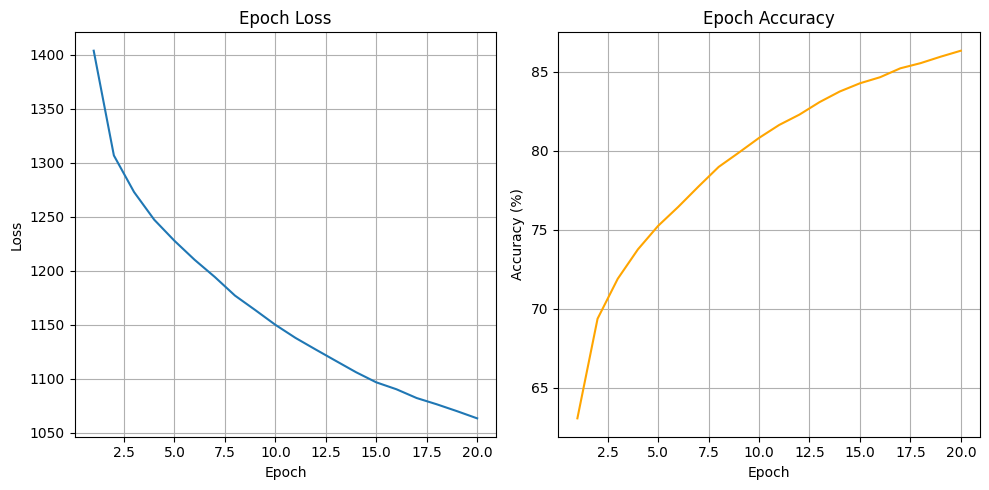

Evaluation Report:
              precision    recall  f1-score   support

          -1       0.62      0.50      0.55      3826
           0       0.61      0.61      0.61      5707
           1       0.47      0.62      0.54      2321

    accuracy                           0.58     11854
   macro avg       0.57      0.58      0.57     11854
weighted avg       0.59      0.58      0.58     11854

Predicted stance for the text: 1


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Importing matplotlib for plotting


class StanceModel:
    def __init__(self, model_dir="saved_models", batch_size=32, epochs=3, device=None):
        self.model_dir = model_dir
        self.analyzer = SentimentIntensityAnalyzer()
        self.model = None
        self.tfidf = None
        self.label_encoder = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        
        # For storing loss and accuracy for plotting
        self.epoch_losses = []
        self.epoch_accuracies = []

    def load_data(self, file_path):
        for encoding in ['utf-8', 'latin1']:
            try:
                return pd.read_csv(file_path,
                                   sep='\t',
                                   encoding=encoding,
                                   engine='python',
                                   on_bad_lines='skip',
                                   names=['label', 'text'],
                                   header=None)
            except Exception:
                continue
        raise ValueError(f"❌ Could not load file: {file_path}")

    def preprocess(self, df):
        df = df.dropna(subset=['text', 'label'])
        texts = df['text'].astype(str).str.strip()
        labels = df['label'].astype(str).str.strip()
        labels = labels[labels != 'label']  # Remove accidental header rows
        texts = texts[labels.index]
        return texts, labels

    def extract_sentiment(self, texts):
        features = []
        for text in texts:
            try:
                sentiment = self.analyzer.polarity_scores(text)
                features.append([sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']])
            except:
                features.append([0, 1.0, 0, 0])  # Neutral fallback
        return np.array(features)

    def fit(self, train_df):
        texts, labels = self.preprocess(train_df)
        sentiment_features = self.extract_sentiment(texts)

        self.tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
        tfidf_features = self.tfidf.fit_transform(texts)

        self.label_encoder = LabelEncoder()
        labels_encoded = self.label_encoder.fit_transform(labels)

        X = np.hstack([tfidf_features.toarray(), sentiment_features])
        y = labels_encoded

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)

        train_data = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        self.model = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(np.unique(y))),
            nn.Softmax(dim=1)
        ).to(self.device)

        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            correct_predictions = 0
            total_predictions = 0

            for batch in train_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()                          # Step 1: Zero old gradients
                outputs = self.model(X_batch)                  # Step 2: Forward pass
                loss = criterion(outputs, y_batch)             # Step 3: Compute loss
                loss.backward()                                # Step 4: Backpropagation
                optimizer.step()                               # Step 5: Update weights

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
                correct_predictions += (predicted == y_batch).sum().item()
                total_predictions += y_batch.size(0)

            accuracy = correct_predictions / total_predictions * 100
            print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {running_loss:.4f} - Accuracy: {accuracy:.2f}%")
            print("Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=self.label_encoder.classes_))

            # Storing loss and accuracy for plotting
            self.epoch_losses.append(running_loss)
            self.epoch_accuracies.append(accuracy)

        self.save()

        # Plotting loss and accuracy
        self.plot_graphs()

    def evaluate(self, test_df):
        texts, labels = self.preprocess(test_df)
        sentiment_features = self.extract_sentiment(texts)
        tfidf_features = self.tfidf.transform(texts)

        labels_encoded = self.label_encoder.transform(labels)
        X = np.hstack([tfidf_features.toarray(), sentiment_features])
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            print("Evaluation Report:")
            print(classification_report(labels_encoded, predicted.cpu(), target_names=self.label_encoder.classes_))

    def save(self):
        os.makedirs(self.model_dir, exist_ok=True)
        torch.save(self.model.state_dict(), os.path.join(self.model_dir, "stance_model.pt"))
        joblib.dump(self.tfidf, os.path.join(self.model_dir, "tfidf_vectorizer.joblib"))
        joblib.dump(self.label_encoder, os.path.join(self.model_dir, "label_encoder.joblib"))
        print(f"✅ Model and components saved to: {self.model_dir}")

    def load(self):
        self.model = nn.Sequential(
            nn.Linear(5000 + 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3),  # Adjust this if you have a different number of classes
            nn.Softmax(dim=1)
        ).to(self.device)
        self.model.load_state_dict(torch.load(os.path.join(self.model_dir, "stance_model.pt"), map_location=self.device))
        self.tfidf = joblib.load(os.path.join(self.model_dir, "tfidf_vectorizer.joblib"))
        self.label_encoder = joblib.load(os.path.join(self.model_dir, "label_encoder.joblib"))
        self.model.eval()

    def predict(self, text):
        if self.model is None or self.tfidf is None:
            self.load()
        sentiment = self.analyzer.polarity_scores(str(text).strip())
        sentiment_features = [[sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']]]
        tfidf_features = self.tfidf.transform([text]).toarray()
        X = np.hstack([tfidf_features, sentiment_features])
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        output = self.model(X_tensor)
        _, predicted = torch.max(output, 1)
        return self.label_encoder.inverse_transform([predicted.item()])[0]

    def plot_graphs(self):
        # Plotting the loss graph
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, self.epochs + 1), self.epoch_losses, label="Loss")
        plt.title("Epoch Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)

        # Plotting the accuracy graph
        plt.subplot(1, 2, 2)
        plt.plot(range(1, self.epochs + 1), self.epoch_accuracies, label="Accuracy", color='orange')
        plt.title("Epoch Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.grid(True)

        plt.tight_layout()
        plt.show()


# === USAGE ===

# Initialize model
model = StanceModel(model_dir="D:/NLP/saved_models", batch_size=32, epochs=20)

# Load and train on training data
train_data = model.load_data("D:/NLP/new/semeval-2017-train.csv")
model.fit(train_data)

# Evaluate on test data
test_data = model.load_data("D:/NLP/new/semeval-2017-test.csv")
model.evaluate(test_data)

# Predict an example
sample_text = "The new policy is absolutely good for our country!"
prediction = model.predict(sample_text)
print(f"Predicted stance for the text: {prediction}")
